In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
function envelope(t)
    if t < 2
        return sin(pi/4*t)^2
    elseif 28 < t <= 30
        return cos(pi/4*(t-28))^2
    else
        return 1
    end
end

# function pulse(p, t)
#     sig = 0
#     l = length(p)÷3
#     As = p[1:l]
#     ωs = p[l+1:2*l]
#     ϕs = p[2*l+1:3*l]
#     for i in range(1,l)
#         sig += As[i] * sin(ωs[i]*t + ϕs[i])
#     end
#     sig*envelope(t)
# end

h_times = LinRange(0,30,200+2)[2:end-1]
dt = h_times[1]
function pulse(p, t)
    out = 0
    w_sum = 0
    for (i, ht) in enumerate(h_times)
        w = exp( - 10/(2*dt^2) * (t - ht)^2)
        out += p[i] * w
        w_sum += w
    end
    envelope(t)*out/w_sum
end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [12]:
# p = 0.5 .* (2 .* rand(200) .- 1)
# forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, 30.0), p)
# sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

# xT = sol_f.u[end][:,1:2]
# UT = abs2.(ψ0'*xT)
# infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
p = readdlm("tmp_params1.txt")[end-1,:];

In [13]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3))
ψ0 = ψs[:,1:2]
sizep = length(p);

function f!(du, u, p, t)
    x = u[:,1:2]
    H = KinPot12 + Potential3 + pulse(p,t) .* chargecoupling

    du[:,1:2] = -im .* (H * x)
end

# M = Pot3Const * exp(im * phi_ext) * Pot3Mat
# Uv = chargecoupling
# Ua = Potential3#Um + Um'
# dUa = M - M'

function b!(du, u, p, t)
    x = u[:,1:2]
    λ = u[:,3:4]
    ps = u[:,5]

    miH = -im .* (KinPot12 + Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * λ
    
    du[1:sizep,5] = - real(im * tr(λ' * chargecoupling * x)) .* dpulsedp(p, t)
end

b! (generic function with 1 method)

In [15]:
ls = []
params = []

grad = zeros(sizep)
loss = [0.0]
calls  = [1]

function calc(p, last_p, grad, loss)
    if p != last_p
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        xT = sol_f.u[end][:,1:2]

        λ = cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,λ,ps,dims=2)#cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])

        loss[1] = infidelity
        grad[:] = real(sol_b.u[end][1:sizep,5]) #+ m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,9])

        push!(ls, copy(infidelity))
        push!(params, copy(p))

        if sum(calls)%10 == 0
            writedlm("tmp_ls2.txt",ls)
            writedlm("tmp_params2.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    push!(calls,1)
    println(ls[end])#,"\n",params[end])
end

get_grad! (generic function with 1 method)

In [16]:
initial_p = copy(p)
last_p = similar(initial_p);

In [17]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()),Optim.Options(g_tol=1e-4,f_tol=1e-6))

0.27574417163330556


0.25941078728264055


0.20286702508205184


0.19462092785329088


0.14197248070694046


0.13036440240550856


0.11201413812248573


0.10442683113391593


0.08981025617283117


0.08357004329481715


0.07537167903356295


0.06849088123743419


0.06254941231573219


0.058739060113990216


0.055173430343928465


0.05132199260937231


0.04758696543620261


0.04481032859676504


0.042716443836218476


0.04079261068326401


0.03884985184263229


0.036971561680133824


0.03509574329772147


0.03322710002682783


0.03155066340404794


0.03014578470171514


0.02882585568938123


0.027450858561118063


0.02618549113640123


0.025162123623394983


0.02423560126402302


0.023167743990691658


0.022028659144107787


0.02113891094043996


0.020503441564476366


0.019879190439913097


0.01904858407252291


0.018132168127242332


0.01744523672218229


0.016992070368421375


0.01659208783105054


0.016134869415508235


0.015704048377302382


0.015379152001516683


0.015094193286226798


0.014736917591554655


0.01431086616173216


0.013944373127800946


0.01367609947165438


0.013420693391317962


0.013092248204968682


0.012717822756156683


0.012416359405419408


0.012188556135100614


0.01192993540658871


0.011592691363943308


0.011286184963666845


0.011103931571902315


0.010979719639164498


0.010821119015813008


0.01060798541548863


0.010391197420302256


0.010221349911842592


0.010075042872543682


0.009909563600318083


0.0097219869812607


0.009548634040515036


0.009394935595976484


0.009226578096834692


0.009015790993407213


0.008797777358074965


0.008616789520500157


0.008472864612972919


0.008330862080504042


0.008182147286853347


0.00804307780272312


0.007924256334700008


In [110]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()),Optim.Options(g_tol=1e-4,f_tol=1e-6))

0.9978334388114771


0.9976908482828651


0.997062083851601


0.9934964826706402


0.9554706135158497

In [108]:
# writedlm("tmp_ls1.txt",ls)
# writedlm("tmp_params1.txt",params)

In [ ]:
readdlm("tmp_ls1.txt")

In [106]:
ls

20-element Vector{Any}:
 0.9978334388114771
 0.9976908482828651
 0.997062083851601
 0.9934964826706402
 0.9554706135158497
 0.49608426472349965
 0.9553282322485588
 0.8360176856204402
 0.9039306225207596
 0.83386275115764
 0.8074964753298408
 0.9891994906327457
 0.9622265706250307
 0.6269890593633847
 0.6120684062575683
 0.520642899277751
 0.4132779637009736
 0.33969268363563054
 0.31707143390420495
 0.27574417163330556

In [69]:
# times = LinRange(0,30,5000)
# tmp = 2 .*rand(200) .-1
# plot([times,h_times], [[pulse(tmp,t) for t in times],zeros(200)])

In [71]:
E1s, ψ1s = eigs(KinPot12 + Potential3, nev=2, which=:SR)
# real(E1s' .- E1s)
;

In [77]:
# p = [1,1,1,1,1,1.5,10.27,11.8,11.68,13.2,0,0,0,0,0]

# times = LinRange(0,30,1000)

# plot(times,[envelope.(times),
#             [pulse(p,t) for t in times]])

In [62]:
function augmented_H_int!(du, u, p, t)
    H = KinPot12 + Potential3
    V = chargecoupling
    hamil = H + pulse(p, t) .* V
    
    a = transpose(reshape(u[1:2*NHilbert],NHilbert,2))
    ψT = reshape(u[2*NHilbert+1:4*NHilbert],NHilbert,2)
    # a = reshape(u[1:NHilbert],1,:)
    # ψT = u[NHilbert+1:2*NHilbert]

    du[1:2*NHilbert] = reshape(transpose(im .* a * hamil),:)
    du[2*NHilbert+1:4*NHilbert] = reshape(-im .* hamil * ψT,:)
    # du[1:NHilbert] = im .* a * hamil
    # du[NHilbert+1:2*NHilbert] = -im .* hamil * ψT
    
    du[4*NHilbert+1:end] = 2*real(im * tr(a * V * ψT)) .* dpulsedp(p, t) #+ 2*real(im * tr(a * Potential3 * ψT)) .* dalphadp(p,t)
    # du[2*NHilbert+1:end] = 2*real(im * a * V * ψT) .* dpulsedp(p, t, ω_qubit, overlap_scale) + 2*real(im * a * Potential3 * ψT) .* dalphadp(p,t)
end

augmented_H_int! (generic function with 1 method)

In [63]:
#buffer = [ω_qubit, overlap_scale, Potential3, ψ1s, ψT, counter]
# counter = 0
ps = []
ls = []

function H_int!(du, u, p, t)
    H = KinPot12 + Potential3
    V = pulse(p, t) .* chargecoupling
    du[:] = - im * (H + V) * u
end


# ψ1s
function calculate_common!(p, last_p, buffer)
    if p != last_p
        copy!(last_p, p)
        buffer[6] += 1
        if buffer[6] % 100 == 0
            writedlm("tmp_ps.txt",ps)
            writedlm("tmp_ls.txt",ls)
        end
        # buffer[3] = get_Pot3(0.995pi)#p[8])
        # Es, ψs = eigs(KinPot12 + p[4] .* buffer[3], nev=2, which=:SR)
        # buffer[1] = real(Es[2] - Es[1])
        # buffer[2] = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

        
        # T = 30.0#p[3] + 2*p[2]
        forward_prob = ODEProblem(H_int!, ψ1s[:,1:2], (0.0, 30.0), p)
        sol = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)
        buffer[5] = sol.u[end]
    end
end

function loss_func(buffer)
    UT = abs2.(ψ1s'*buffer[5])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end

function f(p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    loss = loss_func(buffer)
    push!(ps,copy(last_p))
    push!(ls,copy(loss))
    return loss
end

function g!(storage, p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    ψT = buffer[5]
    a1 = - dropdims(ψT[:,1]'*ψ1s[:,2]*ψ1s[:,2]',dims=1)
    a2 = - dropdims(ψT[:,2]'*ψ1s[:,1]*ψ1s[:,1]',dims=1)

    u0_aug = cat(a1,a2,ψT[:,1],ψT[:,2],zeros(ComplexF64,length(p)),dims=1)
    # u0_aug = cat(a1,ψT[:,1],zeros(ComplexF64,length(p)),dims=1)
    aug_prob = ODEProblem(augmented_H_int!, u0_aug, (30.0,0.0), p)
    aug_sol = solve(aug_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)

    # push!(buffer,aug_sol)
    storage[:] = real(aug_sol.u[end][4*NHilbert+1:end])
    # storage[:] = real(aug_sol.u[end][2*NHilbert+1:end])
end

g! (generic function with 1 method)

In [64]:
initial_p = copy(p)
buffer = [nothing,nothing,nothing,nothing,zeros(ComplexF64,NHilbert,2),0]
last_p = similar(initial_p);

In [42]:
f(initial_p,last_p,buffer)

0.9749625436565325

In [185]:
storage = similar(last_p)
tmp_deriv2 = g!(storage,p,last_p,buffer)

100-element Vector{Float64}:
  0.003636203130013726
 -0.025596341369959596
 -0.01658701774762666
  0.018937341284157076
  0.008772002257556708
 -0.003351808528496967
  0.0008313708455342422
 -0.024091922327009522
 -0.005164367849931856
  0.014045601465814482
  ⋮
 -0.023270606310162947
 -0.0863447198716858
 -0.02072888016861256
  0.08971555856689105
  0.06165870211522222
  0.0011711702008272834
 -0.0453567949565309
 -0.03754610910996184
 -0.014652008007109025

In [70]:
res = optimize(p -> f(p, initial_p, buffer),
               (storage, p) -> g!(storage, p, last_p, buffer),
               initial_p,BFGS(),
               Optim.Options(f_tol=5e-5,g_tol=1e-8,show_every=10))

 * Status: success

 * Candidate solution
    Final objective value:     1.403432e-01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.85e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.05e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.46e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.31e-06 ≤ 5.0e-05
    |g(x)|                 = 1.39e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   5171  (vs limit Inf)
    Iterations:    36
    f(x) calls:    122
    ∇f(x) calls:   122


In [71]:
writedlm("tmp_ps.txt",ps)
writedlm("tmp_ls.txt",ls)
# ps = readdlm("tmp_ps.txt")
# ls = readdlm("tmp_ls.txt");

In [72]:
p_new = copy(Optim.minimizer(res));

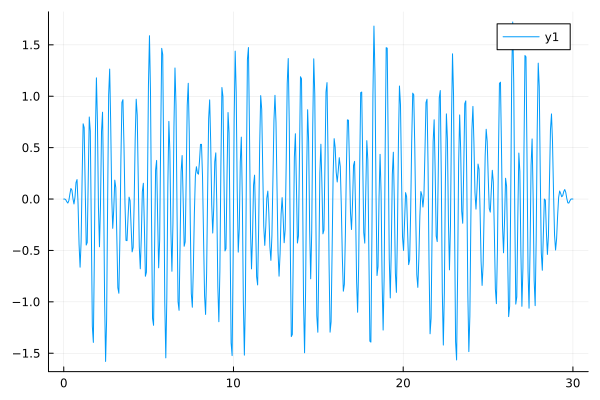

In [178]:
times = LinRange(0,30.0,500)

# plot(times,[[pulse(p_new,t) for t in times],
#             [pulse(p,t) for t in times]])
plot(times,[pulse(p_new,t) for t in times])

In [73]:
res

 * Status: success

 * Candidate solution
    Final objective value:     1.403432e-01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.85e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.05e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.46e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.31e-06 ≤ 5.0e-05
    |g(x)|                 = 1.39e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   5171  (vs limit Inf)
    Iterations:    36
    f(x) calls:    122
    ∇f(x) calls:   122


In [74]:
forward_prob = ODEProblem(H_int!, ψ1s, (0.0, 30.0), p_new)
sol_new = solve(forward_prob, p=p_new, saveat=LinRange(0,30.0,1000), reltol=1e-12, abstol=1e-15)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [6.416797586904819e-10 + 3.801709281005785e-10im 6.579752138153519e-10 - 2.837170782083577e-10im; 5.315693854797455e-9 + 3.4698409787619526e-10im 5.1413053493535435e-9 + 4.424307629844905e-10im; … ; 2.8578402983137963e-9 + 4.495525334249622e-9im 3.207460690849782e-9 - 4.0423954907727385e-9im; 6.416797374238438e-10 + 3.8017094980546406e-10im 6.579752262813613e-10 - 2.83717103765408e-10im]
 [-7.226023939404316e-10 + 1.8475402100281815e-10im -2.336457309279513e-10 + 6.773771311696745e-10im; -4.004922362998

In [176]:
# tmpEs, tmp = eigs(KinPot12 + 0.7265360232227066 .* Potential3, nev=2, which=:SR);
# 2.0448639414672374/real(tmpEs[2] - tmpEs[1])
abs(tmp[:,1]'* chargecoupling * tmp[:,2]) * 4.08982325027897

1.016711382985575

In [151]:
E1s, ψ1s = eigs(KinPot12 + Potential3, nev=287, which=:SR);

In [170]:
tmp = sol_new.u[end][:,1]
2*real(-im * tmp'*ψ1s[:,2]*ψ1s[:,2]'* (Kinetic + Potential3) * tmp)

0.019098861226347325

In [163]:
occs[end,:,:]

287×2 Matrix{Float64}:
 0.00724688   0.840839
 0.878475     0.00926276
 0.0010509    0.00192568
 0.00274324   0.000583777
 0.0275571    0.0470035
 0.00156629   0.0134766
 0.00250662   0.00204183
 0.00275732   0.00134938
 0.00116165   0.00354386
 0.00343655   0.00039913
 ⋮            
 4.52175e-13  2.88765e-13
 1.88647e-14  1.31312e-13
 6.08384e-14  1.31106e-13
 1.08376e-15  4.39797e-15
 3.80823e-16  2.00242e-15
 4.17232e-15  6.19828e-14
 2.31078e-15  1.85286e-14
 2.13405e-22  5.35013e-22
 1.29088e-22  3.02469e-21

In [152]:
occs = zeros(Float64,1000,287,2)
# tmpPot3 = buffer[3]
for (i,t) in enumerate(sol_new.t)
    # tmpEs, tmpψs = eigs(KinPot12 + Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(ψ1s'*sol_new.u[i])
end

In [140]:
zero = cat(occs[:,:,1],abs.(1 .- sum(occs,dims=2)[:,1,[1]]),dims=2)
one = cat(occs[:,:,2],abs.(1 .- sum(occs,dims=2)[:,1,[2]]),dims=2);

In [168]:
p_new[5+1:2*5], 8.48593097/10.2762, 10.894915/11.82, 

5-element Vector{Float64}:
 -8.48593097052304
 10.89491545626589
 17.635532396893257
 16.145708913716696
  6.977443464154187

In [171]:
real(E1s[1:7]' .- E1s[1:7])

7×7 Matrix{Float64}:
   0.0        1.54389   11.8201   13.2305   17.7584   19.8723   22.4753
  -1.54389    0.0       10.2762   11.6866   16.2145   18.3284   20.9315
 -11.8201   -10.2762     0.0       1.41042   5.93833   8.0522   10.6553
 -13.2305   -11.6866    -1.41042   0.0       4.52791   6.64178   9.24487
 -17.7584   -16.2145    -5.93833  -4.52791   0.0       2.11387   4.71696
 -19.8723   -18.3284    -8.0522   -6.64178  -2.11387   0.0       2.60309
 -22.4753   -20.9315   -10.6553   -9.24487  -4.71696  -2.60309   0.0

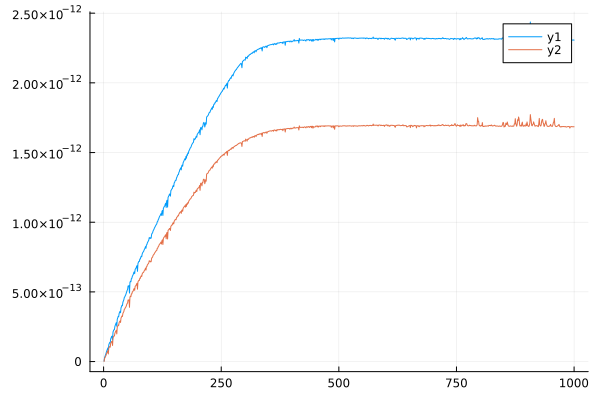

In [131]:
plot(1 .- sum(occs,dims=2)[:,1,:])


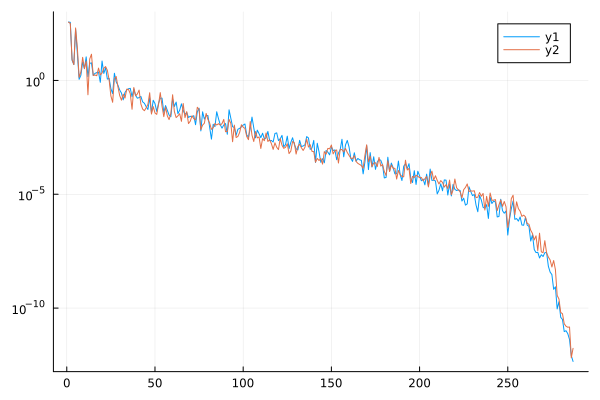

In [162]:
plot([sum(occs,dims=1)[1,:,1],sum(occs,dims=1)[1,:,2]],
    kind="histogram",
    yaxis=:log)

In [173]:
# The optimized run:
# [Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# 2.906667984678622
# 12.109931540601726
# 10.0
# 0.5
# -18.04217394300753
# 6.786309632141689
# 1.83211636655623
# 3.1258846903218442
# -0.05818774908497257

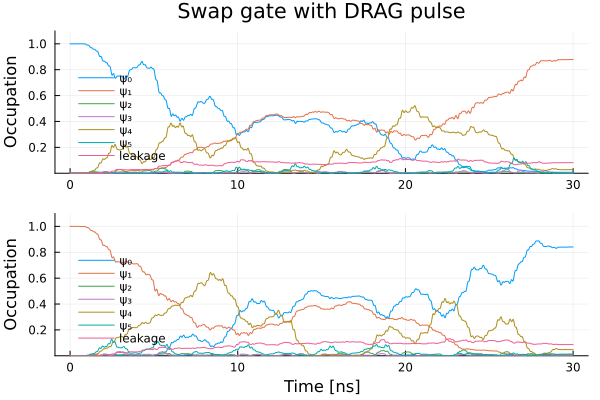

In [150]:
pzero = plot(sol_new.t,zero,title="Swap gate with DRAG pulse")
pone = plot(sol_new.t,one,xlabel="Time [ns]")

# plot(sol_new.t, [zero,one],yaxis=:log,ylims=(1e-10,1.1),layout=(2,1))
outputplot = plot(pzero,pone,
     layout=(2,1),
     # yaxis=:log,
     ylims=(1e-10,1.1),
     legend=:bottomleft,
     label=["ψ₀" "ψ₁" "ψ₂" "ψ₃" "ψ₄" "ψ₅" "leakage"],
     ylabel="Occupation",
     foreground_color_legend = nothing,
     background_color_legend = nothing)

In [166]:
# 
UT = occs[end,:,:]
0.5 * (2 - UT[1,2] - UT[2,1])

0.1403432029633082

In [177]:
# savefig(outputplot,"Figures/SwapOptFourierPulse5waves.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\JuliaStuff\\Figures\\SwapOptFourierPulse5waves.pdf"

In [48]:
tmpEs, tmpψs = eigs(KinPot12 + Potential3, nev=10, which=:SR)
(abs2.(tmpψs'*sol_new.u[end]))

10×2 Matrix{Float64}:
 3.41985e-9  0.999945
 0.999947    6.20638e-9
 6.14343e-6  1.84828e-5
 9.55816e-6  2.05383e-6
 1.20276e-5  1.96376e-5
 2.30988e-5  1.33064e-5
 3.96923e-7  7.68583e-7
 1.16722e-6  1.05994e-7
 1.76384e-7  1.4717e-7
 3.33207e-7  3.01871e-7